In [1]:
# ============================================================
# SINGLE TREND — RE-ORGANIZED (Part 1 + Part 2 + Part 3)
#
# Part 1) Backtest all models (rolling cutoffs, 18M horizon)
#   - backtest_detail.csv
#   - backtest_monthly_org.csv
#   - 9_backtest_summary.csv (includes selection-window metrics)
#
# Part 2) Select winner (cutoffs >= SELECTION_CUTOFF_START)
#   - Winner chosen by: min mean WAPE, then min |bias|, then min sMAPE, then more cutoffs
#
# Part 3) Post-process calibration (k-factor) for the WINNER only
#   - k computed from last CALIB_MONTHS months using "latest-available" history
#   - Outputs aligned to multi-trend style, BUT WITHOUT group column:
#       5_winner_history_latest_available_org_cal.csv
#       6_forecast_winner_18m_org_cal.csv
#       7_winner_models_calibration_and_fy_metrics.csv
#
# Also keeps your deployment “all models” wide file:
#   10_forecast_all_models_18m_org.csv   (wide, org-only)
# ============================================================

import os
import warnings
import numpy as np
import pandas as pd

# -----------------------------
# Configuration
# -----------------------------
BASE_DIR = r"\\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method"
OUTPUT_DIR = os.path.join(BASE_DIR, "Output_SingleTrend")
os.makedirs(OUTPUT_DIR, exist_ok=True)

PATH = os.path.join(BASE_DIR, "0_data_input_monthly.csv")

# Part 1 outputs
OUT_BACKTEST_DETAIL   = os.path.join(OUTPUT_DIR, "backtest_detail.csv")
OUT_BACKTEST_MONTHLY  = os.path.join(OUTPUT_DIR, "backtest_monthly_org.csv")
OUT_BACKTEST_SUMMARY  = os.path.join(OUTPUT_DIR, "9_ST_backtest_summary.csv")

# Deployment (wide) outputs
OUT_FORECAST_ALL_ORG_WIDE = os.path.join(OUTPUT_DIR, "10_ST_forecast_all_models_18m_org.csv")
OUT_FY_TOTALS_ORG_WIDE    = os.path.join(OUTPUT_DIR, "forecast_fy_totals_org.csv")

# Part 3 outputs (aligned to multi-trend style, no group)
OUT_WINNER_HISTORY_CAL = os.path.join(OUTPUT_DIR, "5_ST_winner_history_latest_available_org_cal.csv")
OUT_WINNER_FC_CAL      = os.path.join(OUTPUT_DIR, "6_ST_forecast_winner_18m_org_cal.csv")
OUT_WINNER_METRICS_CAL = os.path.join(OUTPUT_DIR, "7_ST_winner_models_calibration_and_fy_metrics.csv")

# General settings
DATE_COL = "ACC_MONTH"
Y_COL    = "TOT_PAID"
EXOG_COLS = ["BUDGET_AMT", "NBR_MURDER"]

H = 18
TRAIN_WINDOW_MONTHS = 60
MIN_TRAIN_MONTHS = 60
MIN_CUTOFF = pd.Timestamp("2020-03-01")

# Winner selection window (cutoff >= this)
SELECTION_CUTOFF_START = pd.Timestamp("2024-03-01")  # cutoff=2024-03 -> test starts 2024-04
FY_TARGET = "FY2026-27"                               # Apr 2026 - Mar 2027

# Intervention flag for regressors
POST_START = pd.Timestamp("2021-04-01")

# Outlier fill window (same as before)
OUTLIER_START = pd.Timestamp("2020-04-01")
OUTLIER_END   = pd.Timestamp("2021-03-01")

# Lag search
LAG_MIN, LAG_MAX = 0, 12

# Baseline MA seasonal years
SEASONAL_MA_YEARS = 3

# -----------------------------
# Prophet hyperparameters (SET THESE FROM GRID SEARCH)
# -----------------------------
CP = 0.05
SP = 10.0
N_CHANGEPOINTS = 25
CHANGEPOINT_RANGE = 0.90
REG_PRIOR = 0.6

# -----------------------------
# Calibration (k-factor) settings (match multi-trend defaults)
# -----------------------------
CALIB_MONTHS = 18
K_LAMBDA = 0.60     # shrink towards 1.0
K_LOWER  = 0.75     # cap lower
K_UPPER  = 1.25     # cap upper
K_MIN_MONTHS_FOR_K = 12

print("Outputs will be saved to:", OUTPUT_DIR)

# -----------------------------
# Optional dependencies
# -----------------------------
PROPHET_AVAILABLE = False
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except Exception:
    PROPHET_AVAILABLE = False

STATSMODELS_AVAILABLE = False
try:
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    STATSMODELS_AVAILABLE = True
except Exception:
    STATSMODELS_AVAILABLE = False


# ============================================================
# Utilities
# ============================================================
def ensure_dt(s):
    return pd.to_datetime(s, errors="coerce")

def safe_to_csv(df_: pd.DataFrame, path: str, **kwargs) -> str:
    try:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        df_.to_csv(path, **kwargs)
        return path
    except PermissionError:
        fallback = os.path.join(os.getcwd(), os.path.basename(path))
        df_.to_csv(fallback, **kwargs)
        print(f"\n⚠️ PermissionError writing to:\n  {path}\nSaved to local fallback:\n  {fallback}\n")
        return fallback

def safe_read_csv(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        return pd.DataFrame()
    try:
        return pd.read_csv(path)
    except Exception:
        return pd.DataFrame()

def month_start(ts) -> pd.Timestamp:
    ts = pd.Timestamp(ts)
    return ts.to_period("M").to_timestamp(how="start")

def fy_start_year(dt: pd.Timestamp) -> int:
    dt = pd.Timestamp(dt)
    return dt.year if dt.month >= 4 else dt.year - 1

def fiscal_year_label(dt: pd.Timestamp) -> str:
    y = fy_start_year(pd.Timestamp(dt))
    return f"FY{y}-{str(y+1)[-2:]}"


# ============================================================
# Metrics
# ============================================================
def smape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    yt = y_true[m]
    yp = y_pred[m]
    denom = (np.abs(yt) + np.abs(yp))
    denom[denom == 0] = np.nan
    return float(np.nanmean(200.0 * np.abs(yp - yt) / denom))

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    return float(np.sqrt(np.nanmean((y_pred[m] - y_true[m]) ** 2)))

def mase(y_true, y_pred, y_train, m=12):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    y_train = np.asarray(y_train, dtype=float)

    mt = np.isfinite(y_true) & np.isfinite(y_pred)
    if mt.sum() == 0:
        return np.nan

    y_train = y_train[np.isfinite(y_train)]
    if len(y_train) <= m:
        return np.nan
    denom = np.nanmean(np.abs(y_train[m:] - y_train[:-m]))
    if denom == 0 or np.isnan(denom):
        return np.nan
    return float(np.nanmean(np.abs(y_true[mt] - y_pred[mt])) / denom)

def wape(y_true, y_pred):
    """WAPE (%): 100 * sum(|pred-actual|) / sum(|actual|)"""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    denom = np.nansum(np.abs(y_true[m]))
    if denom == 0 or np.isnan(denom):
        return np.nan
    return float(100.0 * (np.nansum(np.abs(y_pred[m] - y_true[m])) / denom))

def bias_wape(y_true, y_pred):
    """Bias% (WAPE-style): 100 * sum(pred-actual) / sum(|actual|)"""
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    if m.sum() == 0:
        return np.nan
    denom = np.nansum(np.abs(y_true[m]))
    if denom == 0 or np.isnan(denom):
        return np.nan
    return float(100.0 * (np.nansum(y_pred[m] - y_true[m]) / denom))


# ============================================================
# Outlier handling
# ============================================================
def fill_outlier_with_past_ma(s: pd.Series, start: pd.Timestamp, end: pd.Timestamp, window_months: int = 24) -> pd.Series:
    s = s.astype(float).copy()
    outlier_idx = s.loc[start:end].index
    for d in outlier_idx:
        hist_end = d - pd.DateOffset(months=1)
        hist_start = d - pd.DateOffset(months=window_months)
        hist = s.loc[hist_start:hist_end].dropna()
        if len(hist) == 0:
            hist2 = s.loc[:hist_end].dropna()
            fill_val = float(hist2.mean()) if len(hist2) else np.nan
        else:
            fill_val = float(hist.tail(window_months).mean())
        s.loc[d] = fill_val
    return s


# ============================================================
# Lag selection & exog features
# ============================================================
def pick_best_lag(train_df, y=Y_COL, x="BUDGET_AMT", lag_min=0, lag_max=12):
    best_lag = 0
    best_abs = -np.inf
    yv = pd.to_numeric(train_df[y], errors="coerce").astype(float)
    xv = pd.to_numeric(train_df[x], errors="coerce")
    for lag in range(lag_min, lag_max + 1):
        xlag = xv.shift(lag)
        corr = pd.concat([yv, xlag], axis=1).corr().iloc[0, 1]
        if np.isfinite(corr) and abs(corr) > best_abs:
            best_abs = abs(corr)
            best_lag = lag
    return best_lag

def make_exog_features(base_df, lag_budget, lag_murder, post_start=POST_START):
    out = pd.DataFrame(index=base_df.index)
    out["BUDGET_L"] = pd.to_numeric(base_df["BUDGET_AMT"], errors="coerce").shift(lag_budget)
    out["MURDER_L"] = pd.to_numeric(base_df["NBR_MURDER"], errors="coerce").shift(lag_murder)
    out["POST"] = (out.index >= post_start).astype(int)
    out["POST_x_BUDGET_L"] = out["POST"] * out["BUDGET_L"]
    out["POST_x_MURDER_L"] = out["POST"] * out["MURDER_L"]
    return out


# ============================================================
# Baseline models
# ============================================================
def fit_predict_seasonal_naive_recursive(train_y: pd.Series, future_index: pd.DatetimeIndex, season=12):
    hist = train_y.astype(float).copy().asfreq("MS")
    preds = []
    for d in future_index:
        ref = d - pd.DateOffset(months=season)
        val = hist.get(ref, np.nan)
        if not np.isfinite(val):
            last = hist.dropna().iloc[-1] if hist.dropna().shape[0] else 0.0
            val = last
        preds.append(float(val))
        hist.loc[d] = float(val)
    return pd.Series(preds, index=future_index, dtype=float)

def fit_predict_seasonal_moving_average(train_y: pd.Series, future_index: pd.DatetimeIndex, years=3):
    y = train_y.astype(float).asfreq("MS").dropna()
    if y.empty:
        return pd.Series(0.0, index=future_index, dtype=float)
    k = max(1, int(years))
    out = []
    for d in future_index:
        same_month = y[y.index.month == d.month]
        out.append(float(y.mean()) if same_month.empty else float(same_month.tail(k).mean()))
    return pd.Series(out, index=future_index, dtype=float)

def fit_predict_ets_robust(train_y: pd.Series, test_index: pd.DatetimeIndex):
    if not STATSMODELS_AVAILABLE:
        return pd.Series(np.nan, index=test_index)

    y = train_y.astype(float).asfreq("MS").dropna()
    if len(y) < 24:
        return fit_predict_seasonal_naive_recursive(y, test_index, season=12)

    specs = [
        dict(trend="add", seasonal="add"),
        dict(trend="add", seasonal=None),
        dict(trend=None, seasonal="add"),
    ]
    if (y > 0).all():
        specs.insert(1, dict(trend="add", seasonal="mul"))

    for sp_ in specs:
        try:
            model = ExponentialSmoothing(
                y,
                trend=sp_["trend"],
                seasonal=sp_["seasonal"],
                seasonal_periods=12 if sp_["seasonal"] is not None else None,
                initialization_method="estimated",
            )
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                res = model.fit(optimized=True)

            fc = res.forecast(len(test_index))
            fc = pd.Series(fc.values, index=test_index, dtype=float)
            if np.isfinite(fc.values).all():
                return fc
        except Exception:
            continue

    return fit_predict_seasonal_naive_recursive(y, test_index, season=12)


# ============================================================
# Prophet helpers (with n_changepoints + changepoint_range)
# ============================================================
def prophet_univar_forecast(train_series: pd.Series, future_index: pd.DatetimeIndex,
                            cp=CP, sp=SP,
                            n_changepoints=N_CHANGEPOINTS,
                            changepoint_range=CHANGEPOINT_RANGE):
    if not PROPHET_AVAILABLE:
        raise RuntimeError("Prophet not available. pip install prophet")

    s = train_series.astype(float).dropna()
    if len(s) < 12:
        return fit_predict_seasonal_naive_recursive(s, future_index, season=12)

    train_df = s.reset_index()
    train_df.columns = ["ds", "y"]

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode="additive",
        changepoint_prior_scale=float(cp),
        seasonality_prior_scale=float(sp),
        n_changepoints=int(n_changepoints),
        changepoint_range=float(changepoint_range),
    )
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        m.fit(train_df)

    fut = pd.DataFrame({"ds": future_index})
    pred = m.predict(fut)["yhat"].values
    return pd.Series(pred, index=future_index, dtype=float)

def prophet_univar_totpaid(train_y: pd.Series, test_index: pd.DatetimeIndex):
    return prophet_univar_forecast(train_y, test_index)

def _ensure_future_regressor(train_series: pd.Series, future_index: pd.DatetimeIndex):
    s = train_series.astype(float).asfreq("MS")
    fc = pd.Series(np.nan, index=future_index, dtype=float)

    if PROPHET_AVAILABLE:
        try:
            fc = prophet_univar_forecast(
                s, future_index,
                cp=CP, sp=SP,
                n_changepoints=N_CHANGEPOINTS,
                changepoint_range=CHANGEPOINT_RANGE
            )
        except Exception:
            fc = pd.Series(np.nan, index=future_index, dtype=float)

    if not np.isfinite(fc.values).all():
        sn = fit_predict_seasonal_naive_recursive(s.dropna(), future_index, season=12)
        fc = fc.where(np.isfinite(fc), sn)

    if not np.isfinite(fc.values).all():
        last = s.dropna().iloc[-1] if s.dropna().shape[0] else 0.0
        fc = fc.fillna(last)

    return fc.astype(float)

def prophet_regressors_with_reg_forecasts(train_df, test_index, lag_budget, lag_murder):
    if not PROPHET_AVAILABLE:
        raise RuntimeError("Prophet not available. pip install prophet")

    train_df = train_df.copy().asfreq("MS")

    bud_future = _ensure_future_regressor(train_df["BUDGET_AMT"], test_index)
    mur_future = _ensure_future_regressor(train_df["NBR_MURDER"], test_index)

    full_index = pd.date_range(train_df.index.min(), test_index.max(), freq="MS")
    base = pd.DataFrame(index=full_index)

    base["BUDGET_AMT"] = train_df["BUDGET_AMT"].reindex(full_index)
    base["NBR_MURDER"] = train_df["NBR_MURDER"].reindex(full_index)

    base.loc[test_index, "BUDGET_AMT"] = bud_future.values
    base.loc[test_index, "NBR_MURDER"] = mur_future.values

    base["BUDGET_AMT"] = base["BUDGET_AMT"].interpolate(limit_direction="both")
    base["NBR_MURDER"] = base["NBR_MURDER"].interpolate(limit_direction="both")

    exog_all = make_exog_features(base, lag_budget, lag_murder).ffill().bfill()

    y_series = train_df[Y_COL].astype(float).rename("y")
    y_series.index.name = "ds"

    exog_train = exog_all.loc[train_df.index].copy()
    exog_train.index.name = "ds"

    p_train = pd.concat([y_series, exog_train], axis=1).dropna().reset_index()
    if p_train.shape[0] < 24:
        return prophet_univar_totpaid(train_df[Y_COL], test_index)

    reg_cols = ["BUDGET_L", "MURDER_L", "POST", "POST_x_BUDGET_L", "POST_x_MURDER_L"]

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode="additive",
        changepoint_prior_scale=float(CP),
        seasonality_prior_scale=float(SP),
        n_changepoints=int(N_CHANGEPOINTS),
        changepoint_range=float(CHANGEPOINT_RANGE),
    )
    for r in reg_cols:
        m.add_regressor(r, prior_scale=REG_PRIOR)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        m.fit(p_train[["ds", "y"] + reg_cols])

    exog_future = exog_all.loc[test_index].copy()
    exog_future.index.name = "ds"
    p_future = exog_future.reset_index()

    pred = m.predict(p_future)[["ds", "yhat"]].set_index("ds")["yhat"].astype(float)
    return pred.reindex(test_index)


# ============================================================
# Winner selection (Part 2)
# ============================================================
def select_winner_model(detail_df: pd.DataFrame, cutoff_start=SELECTION_CUTOFF_START):
    """
    Winner selection on selection window only:
      1) lowest mean WAPE
      2) lowest abs(mean Bias)
      3) lowest mean sMAPE
      4) tie-break: more cutoffs
    Uses cutoffs >= cutoff_start; fallback to all valid cutoffs if selection window is empty.
    """
    if detail_df.empty:
        return None

    d = detail_df.copy()
    d["cutoff"] = ensure_dt(d.get("cutoff"))
    d["ok"] = d.get("ok", True).astype(bool)

    for c in ["WAPE_pct", "Bias_WAPE_pct", "sMAPE"]:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors="coerce")

    d = d[(d["ok"] == True) & np.isfinite(d["WAPE_pct"].values)].copy()
    if d.empty:
        return None

    d_win = d[d["cutoff"] >= cutoff_start].copy()
    if d_win.empty:
        d_win = d.copy()

    agg = (
        d_win.groupby("model", as_index=False)
             .agg(
                 n_cutoffs=("cutoff", "nunique"),
                 wape_mean=("WAPE_pct", "mean"),
                 bias_mean=("Bias_WAPE_pct", "mean"),
                 smape_mean=("sMAPE", "mean"),
             )
    )
    if agg.empty:
        return None

    agg["abs_bias_mean"] = agg["bias_mean"].abs()
    agg = agg.sort_values(
        by=["wape_mean", "abs_bias_mean", "smape_mean", "n_cutoffs"],
        ascending=[True, True, True, False]
    ).reset_index(drop=True)

    return agg.iloc[0].to_dict()


# ============================================================
# Latest-available history (used by Part 3 calibration)
# ============================================================
def latest_available_forecast_rows(monthly_df: pd.DataFrame, model: str) -> pd.DataFrame:
    """
    Return 1 row per ds for the given model:
      - keep only rows where cutoff < ds
      - for each ds, pick row with max cutoff (latest forecast available)
    Requires columns: cutoff, ds, model, y_actual, yhat
    """
    m = monthly_df.copy()
    m["ds"] = ensure_dt(m.get("ds"))
    m["cutoff"] = ensure_dt(m.get("cutoff"))
    m["model"] = m.get("model").astype(str)

    for c in ["y_actual", "yhat"]:
        if c in m.columns:
            m[c] = pd.to_numeric(m[c], errors="coerce")

    m = m.dropna(subset=["ds", "cutoff"]).copy()
    m = m[m["model"] == str(model)].copy()
    m = m[m["cutoff"] < m["ds"]].copy()
    if m.empty:
        return pd.DataFrame()

    m = m.sort_values(["ds", "cutoff"])
    out = m.groupby("ds", as_index=False).tail(1).copy()
    out = out.sort_values("ds").reset_index(drop=True)

    out = out.rename(columns={"cutoff": "cutoff_used", "yhat": "yhat_org"})
    return out[["ds", "cutoff_used", "y_actual", "yhat_org"]]


# ============================================================
# k-factor calibration helpers (Part 3)
# ============================================================
def _k_factor_from_history(hist_df: pd.DataFrame, last_actual_month: pd.Timestamp):
    """
    Compute k-factor from last CALIB_MONTHS months (inclusive), using hist_df which
    contains y_actual and yhat_org (latest-available).

    Returns:
      dict with k stats + window stats + org/cal WAPE & Bias on that window.
    """
    end = month_start(last_actual_month)
    start = month_start(end - pd.DateOffset(months=CALIB_MONTHS - 1))

    h = hist_df.copy()
    h["ds"] = h["ds"].apply(month_start)
    h["y_actual"] = pd.to_numeric(h["y_actual"], errors="coerce")
    h["yhat_org"] = pd.to_numeric(h["yhat_org"], errors="coerce")

    win = h[(h["ds"] >= start) & (h["ds"] <= end)].copy()
    win = win[np.isfinite(win["y_actual"].values) & np.isfinite(win["yhat_org"].values)].copy()

    months_available = int(win["ds"].nunique())

    # Defaults if not enough data
    k_raw = np.nan
    k_shrunk = np.nan
    k_capped = np.nan
    k_factor = 1.0

    actual_sum = float(np.nansum(win["y_actual"].values)) if not win.empty else np.nan
    model_sum  = float(np.nansum(win["yhat_org"].values)) if not win.empty else np.nan

    if months_available >= K_MIN_MONTHS_FOR_K and np.isfinite(model_sum) and model_sum != 0:
        k_raw = actual_sum / model_sum
        k_shrunk = 1.0 + (k_raw - 1.0) * float(K_LAMBDA)
        k_capped = float(np.clip(k_shrunk, float(K_LOWER), float(K_UPPER)))
        k_factor = float(k_capped)

    # Metrics on calib window
    wape_org = wape(win["y_actual"].values, win["yhat_org"].values) if months_available else np.nan
    bias_org = bias_wape(win["y_actual"].values, win["yhat_org"].values) if months_available else np.nan

    yhat_cal = win["yhat_org"].values * k_factor if months_available else np.array([])
    wape_cal = wape(win["y_actual"].values, yhat_cal) if months_available else np.nan
    bias_cal = bias_wape(win["y_actual"].values, yhat_cal) if months_available else np.nan

    out = {
        "calibration_months_requested": int(CALIB_MONTHS),
        "calibration_months_available": int(months_available),
        "calibration_start": start,
        "calibration_end": end,
        "ActualSum_last18m": float(actual_sum) if np.isfinite(actual_sum) else np.nan,
        "ModelSum_last18m": float(model_sum) if np.isfinite(model_sum) else np.nan,
        "k_raw": float(k_raw) if np.isfinite(k_raw) else np.nan,
        "k_shrunk": float(k_shrunk) if np.isfinite(k_shrunk) else np.nan,
        "k_capped": float(k_capped) if np.isfinite(k_capped) else np.nan,
        "k_factor": float(k_factor),
        "k_lambda": float(K_LAMBDA),
        "k_lower": float(K_LOWER),
        "k_upper": float(K_UPPER),
        "k_min_months_for_k": int(K_MIN_MONTHS_FOR_K),
        "WAPE_org_last18m": float(wape_org) if np.isfinite(wape_org) else np.nan,
        "Bias_org_last18m": float(bias_org) if np.isfinite(bias_org) else np.nan,
        "WAPE_cal_last18m": float(wape_cal) if np.isfinite(wape_cal) else np.nan,
        "Bias_cal_last18m": float(bias_cal) if np.isfinite(bias_cal) else np.nan,
        "WAPE_improvement_last18m": (float(wape_org - wape_cal) if np.isfinite(wape_org) and np.isfinite(wape_cal) else np.nan),
        "AbsBias_improvement_last18m": (float(abs(bias_org) - abs(bias_cal)) if np.isfinite(bias_org) and np.isfinite(bias_cal) else np.nan),
    }
    return out

def _fy_ytd_metrics(hist_df: pd.DataFrame, last_actual_month: pd.Timestamp, k_factor: float):
    """
    Compute FY YTD WAPE/Bias on latest-available history, org vs cal.
    """
    end = month_start(last_actual_month)
    fy_label = fiscal_year_label(end)
    fy_start = pd.Timestamp(f"{fy_start_year(end)}-04-01")  # Apr 1 of FY start year

    h = hist_df.copy()
    h["ds"] = h["ds"].apply(month_start)
    h["y_actual"] = pd.to_numeric(h["y_actual"], errors="coerce")
    h["yhat_org"] = pd.to_numeric(h["yhat_org"], errors="coerce")

    win = h[(h["ds"] >= fy_start) & (h["ds"] <= end)].copy()
    win = win[np.isfinite(win["y_actual"].values) & np.isfinite(win["yhat_org"].values)].copy()

    months_available = int(win["ds"].nunique())

    if months_available == 0:
        return {
            "FY_current": fy_label,
            "FY_YTD_months_available": 0,
            "WAPE_org_FY_YTD": np.nan,
            "Bias_org_FY_YTD": np.nan,
            "WAPE_cal_FY_YTD": np.nan,
            "Bias_cal_FY_YTD": np.nan,
        }

    yhat_cal = win["yhat_org"].values * float(k_factor)

    return {
        "FY_current": fy_label,
        "FY_YTD_months_available": int(months_available),
        "WAPE_org_FY_YTD": float(wape(win["y_actual"].values, win["yhat_org"].values)),
        "Bias_org_FY_YTD": float(bias_wape(win["y_actual"].values, win["yhat_org"].values)),
        "WAPE_cal_FY_YTD": float(wape(win["y_actual"].values, yhat_cal)),
        "Bias_cal_FY_YTD": float(bias_wape(win["y_actual"].values, yhat_cal)),
    }


# ============================================================
# Read & prepare data
# ============================================================
df = pd.read_csv(PATH)
df.columns = [c.strip() for c in df.columns]

required = [DATE_COL, Y_COL] + EXOG_COLS
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.dropna(subset=[DATE_COL]).copy()
df[DATE_COL] = df[DATE_COL].dt.to_period("M").dt.to_timestamp(how="start")
df = df.sort_values(DATE_COL).reset_index(drop=True)

for c in [Y_COL] + EXOG_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.set_index(DATE_COL).sort_index().asfreq("MS")
df["POST"] = (df.index >= POST_START).astype(int)

# ✅ Keep a RAW copy for history output (no outlier replacement)
df_raw = df.copy()

# Outlier replacement for MODEL FITTING ONLY (as before)
for c in [Y_COL] + EXOG_COLS:
    df[c] = fill_outlier_with_past_ma(df[c], OUTLIER_START, OUTLIER_END, window_months=24)

df = df.dropna(subset=[Y_COL]).copy()
df_raw = df_raw.dropna(subset=[Y_COL]).copy()

all_months = df.index.dropna()
last_actual_month = pd.Timestamp(all_months.max())
print("Last actual month:", last_actual_month.date())


# ============================================================
# Build rolling-origin cutoffs (Part 1)
# ============================================================
cutoffs = []
for d in all_months:
    if d < MIN_CUTOFF:
        continue
    if d + pd.DateOffset(months=H) <= last_actual_month:
        cutoffs.append(pd.Timestamp(d))

if not cutoffs:
    raise ValueError("No valid cutoffs. Check MIN_CUTOFF, H, and data range.")

print("Cutoffs:", len(cutoffs), "| first:", min(cutoffs).date(), "| last:", max(cutoffs).date())


# ============================================================
# PART 1 — Backtests
# ============================================================
detail_rows = []
monthly_rows = []

def _record_one(cutoff, train_start, train_end, test_start, test_end,
                model, lag_budget, lag_murder, y_train, y_test, pred, err=None):
    pred = pd.Series(pred, index=y_test.index, dtype=float)
    ok = bool(np.isfinite(np.asarray(pred, dtype=float)).all()) and (len(pred) == len(y_test))
    return {
        "cutoff": cutoff,
        "train_start": train_start,
        "train_end": train_end,
        "test_start": test_start,
        "test_end": test_end,
        "model": model,
        "lag_budget": lag_budget,
        "lag_murder": lag_murder,
        "sMAPE": smape(y_test.values, pred.values),
        "WAPE_pct": wape(y_test.values, pred.values),
        "RMSE": rmse(y_test.values, pred.values),
        "MASE": mase(y_test.values, pred.values, y_train.values, m=12),
        "Bias_WAPE_pct": bias_wape(y_test.values, pred.values),
        "ok": ok,
        "error": "" if err is None else str(err)[:500],
    }

def _record_monthly(cutoff, model, y_test: pd.Series, pred: pd.Series):
    pred = pd.Series(pred, index=y_test.index, dtype=float)
    dfm = pd.DataFrame({
        "cutoff": pd.Timestamp(cutoff),
        "ds": y_test.index,
        "model": model,
        "y_actual": pd.to_numeric(y_test.values, errors="coerce"),
        "yhat": pd.to_numeric(pred.values, errors="coerce"),
    })
    monthly_rows.extend(dfm.to_dict("records"))

def _run_and_record(cutoff, train_start, train_end, test_index, model,
                    lag_budget, lag_murder, y_train, y_test, pred, err=None):
    detail_rows.append(_record_one(
        cutoff, train_start, train_end, test_index.min(), test_index.max(),
        model, lag_budget, lag_murder, y_train, y_test, pred, err
    ))
    _record_monthly(cutoff, model, y_test, pred)

for cutoff in cutoffs:
    train_full = df.loc[:cutoff].copy()
    train = train_full.tail(TRAIN_WINDOW_MONTHS).copy()

    test_start = cutoff + pd.DateOffset(months=1)
    test_end = cutoff + pd.DateOffset(months=H)
    test = df.loc[test_start:test_end].copy()
    if test.shape[0] < H:
        continue

    y_train = train[Y_COL].astype(float)
    y_test = test[Y_COL].astype(float)
    test_index = test.index

    if y_train.dropna().shape[0] < MIN_TRAIN_MONTHS:
        continue

    lag_budget = pick_best_lag(train, y=Y_COL, x="BUDGET_AMT", lag_min=LAG_MIN, lag_max=LAG_MAX)
    lag_murder = pick_best_lag(train, y=Y_COL, x="NBR_MURDER", lag_min=LAG_MIN, lag_max=LAG_MAX)

    train_start = train.index.min()
    train_end = train.index.max()

    # M0a
    try:
        pred = fit_predict_seasonal_naive_recursive(y_train, test_index, season=12)
        _run_and_record(cutoff, train_start, train_end, test_index,
                        "M0_SeasonalNaive_recursive", lag_budget, lag_murder, y_train, y_test, pred)
    except Exception as e:
        _run_and_record(cutoff, train_start, train_end, test_index,
                        "M0_SeasonalNaive_recursive", lag_budget, lag_murder, y_train, y_test,
                        pd.Series(np.nan, index=test_index), e)

    # M0b
    try:
        pred = fit_predict_seasonal_moving_average(y_train, test_index, years=SEASONAL_MA_YEARS)
        _run_and_record(cutoff, train_start, train_end, test_index,
                        "M0_SeasonalMovingAverage", lag_budget, lag_murder, y_train, y_test, pred)
    except Exception as e:
        _run_and_record(cutoff, train_start, train_end, test_index,
                        "M0_SeasonalMovingAverage", lag_budget, lag_murder, y_train, y_test,
                        pd.Series(np.nan, index=test_index), e)

    # M1
    try:
        pred = fit_predict_ets_robust(y_train, test_index)
        _run_and_record(cutoff, train_start, train_end, test_index,
                        "M1_ETS_univariate", lag_budget, lag_murder, y_train, y_test, pred)
    except Exception as e:
        pred = fit_predict_seasonal_naive_recursive(y_train, test_index, season=12)
        _run_and_record(cutoff, train_start, train_end, test_index,
                        "M1_ETS_univariate", lag_budget, lag_murder, y_train, y_test, pred, e)

    if PROPHET_AVAILABLE:
        # M2
        try:
            pred = prophet_univar_totpaid(y_train, test_index)
            _run_and_record(cutoff, train_start, train_end, test_index,
                            "M2_Prophet_univariate", lag_budget, lag_murder, y_train, y_test, pred)
        except Exception as e:
            _run_and_record(cutoff, train_start, train_end, test_index,
                            "M2_Prophet_univariate", lag_budget, lag_murder, y_train, y_test,
                            pd.Series(np.nan, index=test_index), e)

        # M3
        try:
            train_df_m3 = train[[Y_COL] + EXOG_COLS].copy()
            pred = prophet_regressors_with_reg_forecasts(train_df_m3, test_index, lag_budget, lag_murder)
            _run_and_record(cutoff, train_start, train_end, test_index,
                            "M3_Prophet_regressors_regForecast", lag_budget, lag_murder, y_train, y_test, pred)
        except Exception as e:
            pred = prophet_univar_totpaid(y_train, test_index)
            _run_and_record(cutoff, train_start, train_end, test_index,
                            "M3_Prophet_regressors_regForecast", lag_budget, lag_murder, y_train, y_test, pred, e)

# Save Part 1 outputs
detail = pd.DataFrame(detail_rows)
safe_to_csv(detail, OUT_BACKTEST_DETAIL, index=False)

monthly_df = pd.DataFrame(monthly_rows)
monthly_df["cutoff"] = ensure_dt(monthly_df["cutoff"])
monthly_df["ds"] = ensure_dt(monthly_df["ds"])
monthly_df["model"] = monthly_df["model"].astype(str)
for c in ["y_actual", "yhat"]:
    monthly_df[c] = pd.to_numeric(monthly_df[c], errors="coerce")
safe_to_csv(monthly_df, OUT_BACKTEST_MONTHLY, index=False)

# Build 9_backtest_summary.csv (incl. selection-window metrics)
detail_sum = detail.copy()
detail_sum["cutoff"] = ensure_dt(detail_sum["cutoff"])
detail_sum["ok"] = detail_sum.get("ok", True).astype(bool)
for c in ["WAPE_pct", "Bias_WAPE_pct", "sMAPE", "RMSE", "MASE"]:
    if c in detail_sum.columns:
        detail_sum[c] = pd.to_numeric(detail_sum[c], errors="coerce")

summary_all = (
    detail_sum.groupby(["model"], as_index=False)
              .agg(
                  smape_mean=("sMAPE", "mean"),
                  smape_median=("sMAPE", "median"),
                  wape_mean=("WAPE_pct", "mean"),
                  wape_median=("WAPE_pct", "median"),
                  rmse_mean=("RMSE", "mean"),
                  mase_mean=("MASE", "mean"),
                  bias_wape_mean=("Bias_WAPE_pct", "mean"),
                  n_ok=("ok", "sum"),
                  n_total=("ok", "count"),
              )
)

detail_sel = detail_sum[
    (detail_sum["ok"] == True)
    & (detail_sum["cutoff"] >= SELECTION_CUTOFF_START)
    & np.isfinite(detail_sum["WAPE_pct"].values)
].copy()

if detail_sel.empty:
    summary_sel = summary_all[["model"]].copy()
    summary_sel["n_cutoffs_selection"] = 0
    summary_sel["wape_mean_selection"] = np.nan
    summary_sel["bias_mean_selection"] = np.nan
    summary_sel["smape_mean_selection"] = np.nan
else:
    summary_sel = (
        detail_sel.groupby("model", as_index=False)
                  .agg(
                      n_cutoffs_selection=("cutoff", "nunique"),
                      wape_mean_selection=("WAPE_pct", "mean"),
                      bias_mean_selection=("Bias_WAPE_pct", "mean"),
                      smape_mean_selection=("sMAPE", "mean"),
                  )
    )

summary = summary_all.merge(summary_sel, on="model", how="left")
safe_to_csv(summary, OUT_BACKTEST_SUMMARY, index=False)

print("✅ Part 1 complete:",
      "\n -", OUT_BACKTEST_DETAIL,
      "\n -", OUT_BACKTEST_MONTHLY,
      "\n -", OUT_BACKTEST_SUMMARY)


# ============================================================
# Deployment forecasts (wide, org-only) — keep as before
# ============================================================
future_idx = pd.date_range(last_actual_month + pd.DateOffset(months=1), periods=H, freq="MS")

deploy_train = df.loc[:last_actual_month].tail(TRAIN_WINDOW_MONTHS).copy()
y_deploy = deploy_train[Y_COL].astype(float)

fc_wide = pd.DataFrame({"ds": future_idx})
fc_wide["M0_SeasonalNaive_recursive"] = fit_predict_seasonal_naive_recursive(y_deploy, future_idx, season=12).values
fc_wide["M0_SeasonalMovingAverage"]   = fit_predict_seasonal_moving_average(y_deploy, future_idx, years=SEASONAL_MA_YEARS).values
fc_wide["M1_ETS_univariate"]          = fit_predict_ets_robust(y_deploy, future_idx).values

if PROPHET_AVAILABLE:
    fc_wide["M2_Prophet_univariate"] = prophet_univar_totpaid(y_deploy, future_idx).values
else:
    fc_wide["M2_Prophet_univariate"] = np.nan

lag_budget_full = pick_best_lag(deploy_train, y=Y_COL, x="BUDGET_AMT", lag_min=LAG_MIN, lag_max=LAG_MAX)
lag_murder_full = pick_best_lag(deploy_train, y=Y_COL, x="NBR_MURDER", lag_min=LAG_MIN, lag_max=LAG_MAX)

if PROPHET_AVAILABLE:
    try:
        train_df_full = deploy_train[[Y_COL] + EXOG_COLS].copy()
        fc_wide["M3_Prophet_regressors_regForecast"] = prophet_regressors_with_reg_forecasts(
            train_df_full, future_idx, lag_budget_full, lag_murder_full
        ).values
    except Exception:
        fc_wide["M3_Prophet_regressors_regForecast"] = fc_wide["M2_Prophet_univariate"].values
else:
    fc_wide["M3_Prophet_regressors_regForecast"] = np.nan

safe_to_csv(fc_wide, OUT_FORECAST_ALL_ORG_WIDE, index=False)

fc_wide_fy = fc_wide.copy()
fc_wide_fy["FY"] = fc_wide_fy["ds"].apply(lambda x: fiscal_year_label(pd.Timestamp(x)))
fy_org = fc_wide_fy.groupby("FY").sum(numeric_only=True).reset_index()
safe_to_csv(fy_org, OUT_FY_TOTALS_ORG_WIDE, index=False)

print("✅ Deployment (wide) saved:",
      "\n -", OUT_FORECAST_ALL_ORG_WIDE,
      "\n -", OUT_FY_TOTALS_ORG_WIDE)


# ============================================================
# PART 2 — Select winner
# ============================================================
winner = select_winner_model(detail, cutoff_start=SELECTION_CUTOFF_START)
if winner is None:
    raise RuntimeError("No valid winner found (check backtest_detail.csv).")

winner_model = str(winner["model"])
n_cutoffs_used = int(winner.get("n_cutoffs", 0))
selection_wape_mean = float(winner.get("wape_mean", np.nan))
selection_bias_mean = float(winner.get("bias_mean", np.nan))
selection_abs_bias_mean = float(winner.get("abs_bias_mean", np.nan))
selection_smape_mean = float(winner.get("smape_mean", np.nan))

print(f"✅ Winner model: {winner_model}")


# ============================================================
# PART 3 — Calibration + Multi-trend-aligned outputs (no group)
# ============================================================

# 3A) Build latest-available history for winner from backtest_monthly_org
hist_core = latest_available_forecast_rows(monthly_df, winner_model)
if hist_core.empty:
    raise RuntimeError(f"Could not build latest-available history for winner model: {winner_model}")

# ✅ Merge RAW actuals + RAW regressors from original input (NO outlier replacement) for HISTORY OUTPUT
raw_hist = df_raw[[Y_COL] + EXOG_COLS].copy()
raw_hist = raw_hist.reset_index().rename(columns={DATE_COL: "ds"})
raw_hist["ds"] = ensure_dt(raw_hist["ds"]).apply(month_start)
raw_hist = raw_hist.groupby("ds", as_index=False).agg({
    Y_COL: "sum",
    "BUDGET_AMT": "sum",
    "NBR_MURDER": "sum",
})
raw_hist = raw_hist.rename(columns={
    Y_COL: "y_actual_raw",
    "BUDGET_AMT": "Budget_AMT",
    "NBR_MURDER": "Nbr_Cases",
})

hist = hist_core.copy()
hist["ds"] = hist["ds"].apply(month_start)
hist = hist.merge(raw_hist, on="ds", how="left")

# Overwrite y_actual with RAW wherever available (keeps model fitting untouched; fixes history feed)
hist["y_actual"] = pd.to_numeric(hist.get("y_actual_raw"), errors="coerce").combine_first(
    pd.to_numeric(hist.get("y_actual"), errors="coerce")
)
hist = hist.drop(columns=[c for c in ["y_actual_raw"] if c in hist.columns])

# Add FY/segment/model
hist["FY"] = hist["ds"].apply(fiscal_year_label)
hist["segment"] = "history"
hist["winner_model"] = winner_model

# 3B) Compute k-factor from last CALIB_MONTHS months
k_stats = _k_factor_from_history(hist, last_actual_month)

k_factor = float(k_stats["k_factor"])

# Apply calibration to history
hist["k_factor"] = k_factor
hist["yhat_cal"] = pd.to_numeric(hist["yhat_org"], errors="coerce") * k_factor

hist["error_org"] = pd.to_numeric(hist["yhat_org"], errors="coerce") - pd.to_numeric(hist["y_actual"], errors="coerce")
hist["error_cal"] = pd.to_numeric(hist["yhat_cal"], errors="coerce") - pd.to_numeric(hist["y_actual"], errors="coerce")
hist["abs_error_org"] = np.abs(hist["error_org"])
hist["abs_error_cal"] = np.abs(hist["error_cal"])

# Match multi-trend winner history columns (WITHOUT group)
hist_out = hist[[
    "ds", "FY", "segment", "winner_model", "k_factor", "cutoff_used",
    "Budget_AMT", "Nbr_Cases",
    "y_actual", "yhat_org", "yhat_cal",
    "error_org", "error_cal", "abs_error_org", "abs_error_cal"
]].sort_values("ds").reset_index(drop=True)

safe_to_csv(hist_out, OUT_WINNER_HISTORY_CAL, index=False)

# 3C) Winner forecast (next 18M): use deployment wide forecast for the winner model
fc_win = pd.DataFrame({
    "winner_model": winner_model,
    "ds": future_idx,
    "yhat_org": pd.to_numeric(fc_wide[winner_model], errors="coerce").values if winner_model in fc_wide.columns else np.nan
})

fc_win["yhat_cal"] = fc_win["yhat_org"] * k_factor
fc_win["k_factor"] = k_factor
fc_win["k_raw"] = k_stats["k_raw"]
fc_win["k_shrunk"] = k_stats["k_shrunk"]
fc_win["k_capped"] = k_stats["k_capped"]

# Match multi-trend winner forecast columns (WITHOUT group)
fc_win_out = fc_win[[
    "winner_model", "ds", "yhat_org", "yhat_cal", "k_factor", "k_raw", "k_shrunk", "k_capped"
]].sort_values("ds").reset_index(drop=True)

safe_to_csv(fc_win_out, OUT_WINNER_FC_CAL, index=False)

# 3D) FY target totals (org vs cal) from forecast
fc_for_fy = fc_win.copy()
fc_for_fy["FY"] = fc_for_fy["ds"].apply(fiscal_year_label)
fy_rows = fc_for_fy[fc_for_fy["FY"] == FY_TARGET].copy()
fy_months_covered = int(fy_rows["ds"].nunique())
fy_org_total = float(np.nansum(fy_rows["yhat_org"].values)) if fy_months_covered else np.nan
fy_cal_total = float(np.nansum(fy_rows["yhat_cal"].values)) if fy_months_covered else np.nan

# 3E) FY YTD metrics (org vs cal) on history
fy_ytd = _fy_ytd_metrics(hist, last_actual_month, k_factor)

# 3F) Winner metrics table aligned to multi-trend file (WITHOUT group)
winner_metrics = {
    "winner_model": winner_model,
    "selection_cutoff_start": (SELECTION_CUTOFF_START + pd.DateOffset(months=1)).date(),  # report "window starts" like multi-trend
    "n_cutoffs_used": int(n_cutoffs_used),
    "selection_wape_mean": float(selection_wape_mean),
    "selection_bias_mean": float(selection_bias_mean),
    "selection_abs_bias_mean": float(selection_abs_bias_mean),
    "selection_smape_mean": float(selection_smape_mean),
    "last_actual_month": month_start(last_actual_month).date(),
    **k_stats,
    **fy_ytd,
}

# Add FY target org/cal totals + some convenience metrics (kept simple & PowerBI-friendly)
winner_metrics["FY_target"] = FY_TARGET
winner_metrics["FY_target_months_covered"] = fy_months_covered
winner_metrics["FY_target_forecast_org"] = fy_org_total
winner_metrics["FY_target_forecast_cal"] = fy_cal_total

winner_metrics_df = pd.DataFrame([winner_metrics])

# Keep column order close to multi-trend's (minus group)
multi_like_order = [
    "winner_model",
    "selection_cutoff_start",
    "n_cutoffs_used",
    "selection_wape_mean",
    "selection_bias_mean",
    "selection_abs_bias_mean",
    "selection_smape_mean",
    "last_actual_month",
    "calibration_months_requested",
    "calibration_months_available",
    "calibration_start",
    "calibration_end",
    "ActualSum_last18m",
    "ModelSum_last18m",
    "k_raw",
    "k_shrunk",
    "k_capped",
    "k_factor",
    "k_lambda",
    "k_lower",
    "k_upper",
    "k_min_months_for_k",
    "WAPE_org_last18m",
    "Bias_org_last18m",
    "WAPE_cal_last18m",
    "Bias_cal_last18m",
    "WAPE_improvement_last18m",
    "AbsBias_improvement_last18m",
    "FY_current",
    "FY_YTD_months_available",
    "WAPE_org_FY_YTD",
    "Bias_org_FY_YTD",
    "WAPE_cal_FY_YTD",
    "Bias_cal_FY_YTD",
    "FY_target",
    "FY_target_months_covered",
    "FY_target_forecast_org",
    "FY_target_forecast_cal",
]
# Only keep those that exist (avoid KeyError if something changes)
multi_like_order = [c for c in multi_like_order if c in winner_metrics_df.columns]
winner_metrics_df = winner_metrics_df[multi_like_order]

safe_to_csv(winner_metrics_df, OUT_WINNER_METRICS_CAL, index=False)

print("✅ Part 3 complete (calibration + aligned outputs):",
      "\n -", OUT_WINNER_HISTORY_CAL,
      "\n -", OUT_WINNER_FC_CAL,
      "\n -", OUT_WINNER_METRICS_CAL)

Outputs will be saved to: \\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_SingleTrend
Last actual month: 2025-12-01
Cutoffs: 52 | first: 2020-03-01 | last: 2024-06-01


16:49:44 - cmdstanpy - INFO - Chain [1] start processing
16:49:44 - cmdstanpy - INFO - Chain [1] done processing
16:49:48 - cmdstanpy - INFO - Chain [1] start processing
16:49:49 - cmdstanpy - INFO - Chain [1] done processing
16:49:50 - cmdstanpy - INFO - Chain [1] start processing
16:49:50 - cmdstanpy - INFO - Chain [1] done processing
16:49:51 - cmdstanpy - INFO - Chain [1] start processing
16:49:51 - cmdstanpy - INFO - Chain [1] done processing
16:49:52 - cmdstanpy - INFO - Chain [1] start processing
16:49:52 - cmdstanpy - INFO - Chain [1] done processing
16:49:53 - cmdstanpy - INFO - Chain [1] start processing
16:49:54 - cmdstanpy - INFO - Chain [1] done processing
16:49:54 - cmdstanpy - INFO - Chain [1] start processing
16:49:55 - cmdstanpy - INFO - Chain [1] done processing
16:49:55 - cmdstanpy - INFO - Chain [1] start processing
16:49:56 - cmdstanpy - INFO - Chain [1] done processing
16:49:56 - cmdstanpy - INFO - Chain [1] start processing
16:49:56 - cmdstanpy - INFO - Chain [1]

✅ Part 1 complete: 
 - \\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_SingleTrend\backtest_detail.csv 
 - \\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_SingleTrend\backtest_monthly_org.csv 
 - \\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_SingleTrend\9_ST_backtest_summary.csv


16:53:11 - cmdstanpy - INFO - Chain [1] start processing
16:53:11 - cmdstanpy - INFO - Chain [1] done processing
16:53:11 - cmdstanpy - INFO - Chain [1] start processing
16:53:12 - cmdstanpy - INFO - Chain [1] done processing
16:53:12 - cmdstanpy - INFO - Chain [1] start processing
16:53:12 - cmdstanpy - INFO - Chain [1] done processing
16:53:13 - cmdstanpy - INFO - Chain [1] start processing
16:53:13 - cmdstanpy - INFO - Chain [1] done processing


✅ Deployment (wide) saved: 
 - \\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_SingleTrend\10_ST_forecast_all_models_18m_org.csv 
 - \\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_SingleTrend\forecast_fy_totals_org.csv
✅ Winner model: M2_Prophet_univariate
✅ Part 3 complete (calibration + aligned outputs): 
 - \\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_SingleTrend\5_ST_winner_history_latest_available_org_cal.csv 
 - \\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_SingleTrend\6_ST_forecast_winner_18m_org_cal.csv 
 - \\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_Singl

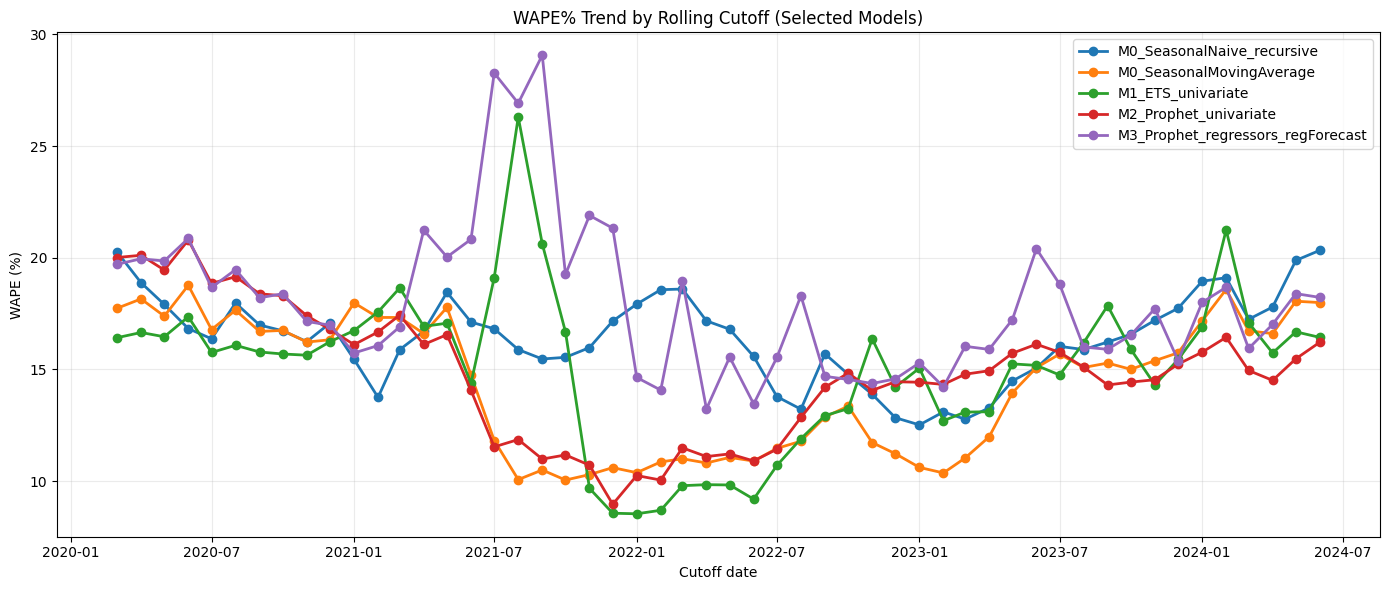

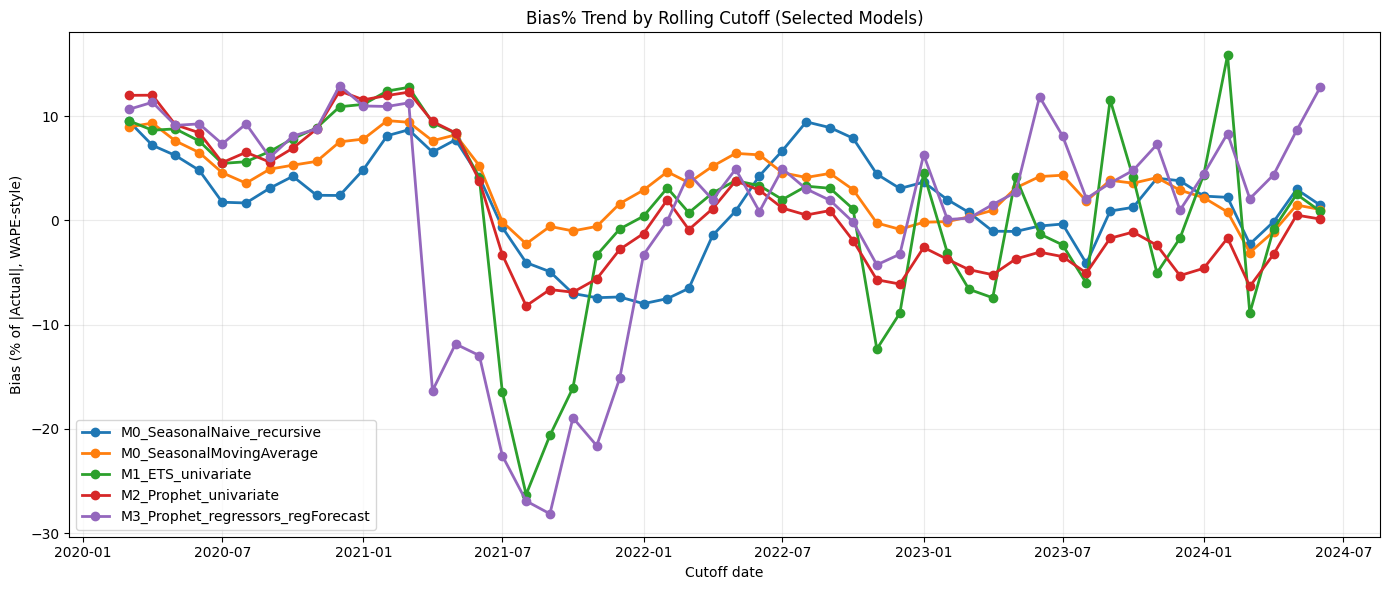

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Paths ----
BASE_DIR = r"\\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_SingleTrend"
DETAIL_CSV = os.path.join(BASE_DIR, "backtest_detail.csv")

# ---- Choose which models to plot (edit this list) ----
# NOTE: plusDrift removed
MODELS_TO_PLOT = [
    "M0_SeasonalNaive_recursive",
    "M0_SeasonalMovingAverage",
    "M1_ETS_univariate",
    "M2_Prophet_univariate",
    "M3_Prophet_regressors_regForecast",
]

# If your detail file still contains "variant" (org/cal), choose which one to plot:
VARIANT_TO_PLOT = "org"  # ignored if no 'variant' column exists

# Governance guide lines
BIAS_OK = 3.0
BIAS_WATCH = 5.0
WAPE_OK = 10.0
WAPE_WATCH = 15.0

SHOW_LEGEND = True

# -----------------------------
# Read + prep
# -----------------------------
detail = pd.read_csv(DETAIL_CSV)

# Standardize types/columns
detail["cutoff"] = pd.to_datetime(detail["cutoff"], errors="coerce")
detail["model"] = detail["model"].astype(str)

# Optional variant filtering (if the file contains it)
if "variant" in detail.columns:
    detail["variant"] = detail["variant"].astype(str)
    detail = detail[detail["variant"].str.lower() == VARIANT_TO_PLOT.lower()].copy()

# Coerce metrics
for c in ["WAPE_pct", "Bias_WAPE_pct", "sMAPE", "RMSE", "MASE"]:
    if c in detail.columns:
        detail[c] = pd.to_numeric(detail[c], errors="coerce")

# ok column sometimes is 0/1 or True/False or string
if "ok" in detail.columns:
    if detail["ok"].dtype == object:
        detail["ok"] = detail["ok"].astype(str).str.lower().isin(["true", "1", "yes"])
    else:
        detail["ok"] = detail["ok"].astype(bool)
else:
    detail["ok"] = True  # fallback

# Filter to valid rows
dfp = detail[(detail["ok"] == True) & detail["cutoff"].notna()].copy()

# Enforce model list (and auto-drop plusDrift even if someone added it)
dfp = dfp[dfp["model"].isin(MODELS_TO_PLOT)].copy()

# -----------------------------
# Build pivots (cutoff x model)
# -----------------------------
def make_pivot(metric_col: str) -> pd.DataFrame:
    if metric_col not in dfp.columns:
        raise ValueError(f"Column '{metric_col}' not found in {DETAIL_CSV}")
    p = (
        dfp.pivot_table(index="cutoff", columns="model", values=metric_col, aggfunc="mean")
           .sort_index()
    )
    return p

wape_pivot = make_pivot("WAPE_pct")
bias_pivot = make_pivot("Bias_WAPE_pct")

# -----------------------------
# Plot: WAPE trend
# -----------------------------
plt.figure(figsize=(14, 6))

for m in MODELS_TO_PLOT:
    if m in wape_pivot.columns:
        plt.plot(wape_pivot.index, wape_pivot[m], marker="o", linewidth=2, label=m)

# OK/WATCH reference lines
#plt.axhline(WAPE_OK, linestyle="--", linewidth=2)
#plt.axhline(WAPE_WATCH, linestyle="--", linewidth=1)

plt.title("WAPE% Trend by Rolling Cutoff (Selected Models)")
plt.xlabel("Cutoff date")
plt.ylabel("WAPE (%)")
plt.grid(True, alpha=0.25)

if SHOW_LEGEND:
    plt.legend()

plt.tight_layout()
plt.show()

# -----------------------------
# Plot: Bias trend
# -----------------------------
plt.figure(figsize=(14, 6))

for m in MODELS_TO_PLOT:
    if m in bias_pivot.columns:
        plt.plot(bias_pivot.index, bias_pivot[m], marker="o", linewidth=2, label=m)

# Normal bias range +/-3% (OK) and optional +/-5% (Watch)
#plt.axhline(+BIAS_OK, linestyle="--", linewidth=2)
#plt.axhline(-BIAS_OK, linestyle="--", linewidth=2)
#plt.axhline(+BIAS_WATCH, linestyle="--", linewidth=1)
#plt.axhline(-BIAS_WATCH, linestyle="--", linewidth=1)

plt.title("Bias% Trend by Rolling Cutoff (Selected Models)")
plt.xlabel("Cutoff date")
plt.ylabel("Bias (% of |Actual|, WAPE-style)")
plt.grid(True, alpha=0.25)

if SHOW_LEGEND:
    plt.legend()

plt.tight_layout()
plt.show()


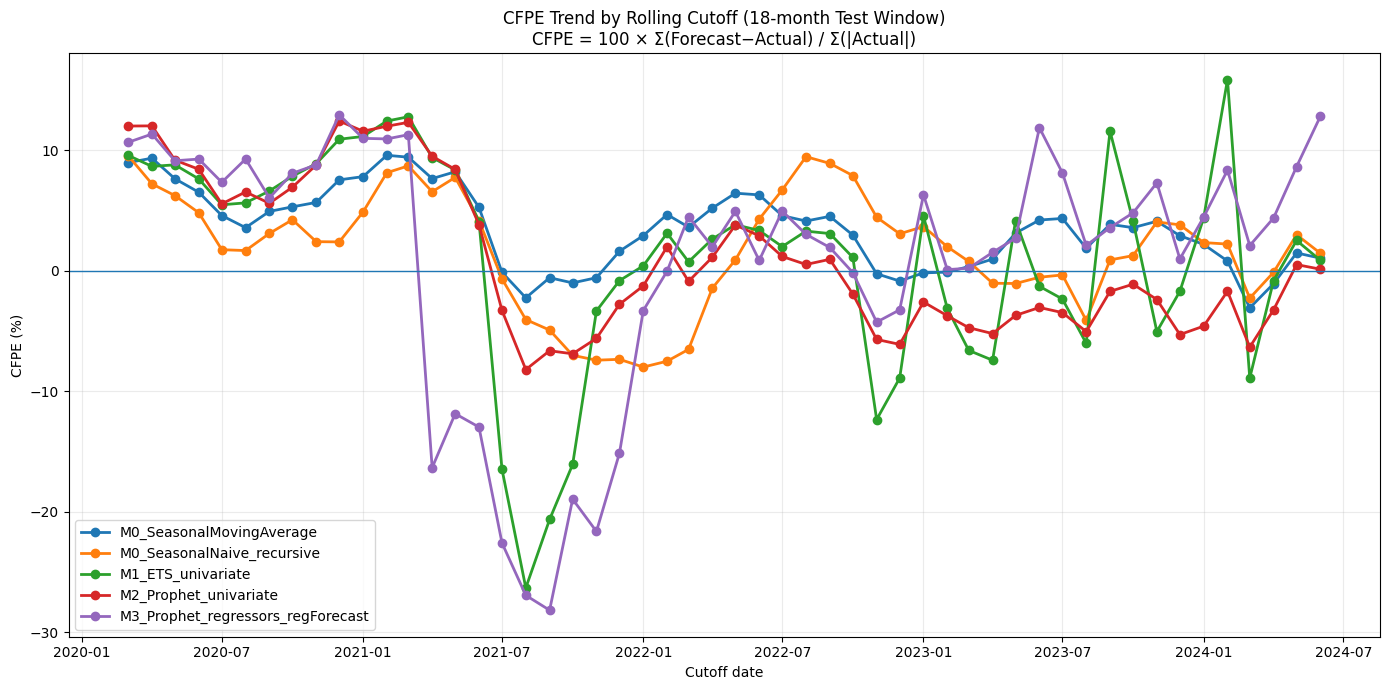


CFPE table (first 10 rows):
      cutoff                              model  test_months  total_actual  \
0 2020-03-01           M0_SeasonalMovingAverage           18  3.496607e+07   
1 2020-03-01         M0_SeasonalNaive_recursive           18  3.496607e+07   
2 2020-03-01                  M1_ETS_univariate           18  3.496607e+07   
3 2020-03-01              M2_Prophet_univariate           18  3.496607e+07   
4 2020-03-01  M3_Prophet_regressors_regForecast           18  3.496607e+07   
5 2020-04-01           M0_SeasonalMovingAverage           18  3.477431e+07   
6 2020-04-01         M0_SeasonalNaive_recursive           18  3.477431e+07   
7 2020-04-01                  M1_ETS_univariate           18  3.477431e+07   
8 2020-04-01              M2_Prophet_univariate           18  3.477431e+07   
9 2020-04-01  M3_Prophet_regressors_regForecast           18  3.477431e+07   

   total_abs_actual  total_forecast           CFE   CFPE_pct  \
0      3.496607e+07    3.809732e+07  3.131252e+0

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------
# Paths
# -------------------------------------------------
BASE_DIR = r"\\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\Output_SingleTrend"
MONTHLY_CSV = os.path.join(BASE_DIR, "backtest_monthly_org.csv")  # or backtest_monthly_org_cal.csv

# -------------------------------------------------
# Settings
# -------------------------------------------------
VARIANT_FILTER = None  # "org" / "cal" / None
MODELS_TO_PLOT = None  # or list of models
SHOW_LEGEND = True

# -------------------------------------------------
# Read + prep
# -------------------------------------------------
m = pd.read_csv(MONTHLY_CSV)

for col in ["cutoff", "ds"]:
    if col in m.columns:
        m[col] = pd.to_datetime(m[col], errors="coerce")

# Ensure column names exist
if "y_actual" not in m.columns:
    for alt in ["actual", "y", "ACTUAL", "TOT_PAID"]:
        if alt in m.columns:
            m = m.rename(columns={alt: "y_actual"})
            break

if "yhat" not in m.columns:
    for alt in ["forecast", "y_pred", "yhat_org", "pred"]:
        if alt in m.columns:
            m = m.rename(columns={alt: "yhat"})
            break

required = {"cutoff", "ds", "model", "y_actual", "yhat"}
missing = sorted(list(required - set(m.columns)))
if missing:
    raise ValueError(f"Missing required columns in {MONTHLY_CSV}: {missing}")

m["y_actual"] = pd.to_numeric(m["y_actual"], errors="coerce")
m["yhat"] = pd.to_numeric(m["yhat"], errors="coerce")

if VARIANT_FILTER is not None and "variant" in m.columns:
    m = m[m["variant"].astype(str).str.lower() == str(VARIANT_FILTER).lower()].copy()

m = m[np.isfinite(m["y_actual"].values) & np.isfinite(m["yhat"].values)].copy()

if MODELS_TO_PLOT is not None:
    m = m[m["model"].isin(MODELS_TO_PLOT)].copy()

# -------------------------------------------------
# Compute CFPE per cutoff+model (+variant)
# CFPE (%) = 100 * sum(forecast-actual) / sum(|actual|)
# -------------------------------------------------
group_cols = ["cutoff", "model"]
if "variant" in m.columns:
    group_cols.append("variant")

m["error"] = m["yhat"] - m["y_actual"]
m["abs_actual"] = np.abs(m["y_actual"])

agg = (
    m.groupby(group_cols, as_index=False)
     .agg(
         test_months=("ds", "nunique"),
         total_actual=("y_actual", "sum"),
         total_abs_actual=("abs_actual", "sum"),
         total_forecast=("yhat", "sum"),
         CFE=("error", "sum"),
     )
)

# CFPE
den = agg["total_abs_actual"].replace(0, np.nan)
agg["CFPE_pct"] = 100.0 * (agg["CFE"] / den)

# -------------------------------------------------
# Pivot for plotting
# -------------------------------------------------
if "variant" in agg.columns:
    agg["series_name"] = agg["model"].astype(str) + "_" + agg["variant"].astype(str)
else:
    agg["series_name"] = agg["model"].astype(str)

pivot = (
    agg.pivot_table(index="cutoff", columns="series_name", values="CFPE_pct", aggfunc="mean")
       .sort_index()
)

# optional ordering
series_order = list(pivot.columns)
if MODELS_TO_PLOT is not None:
    if "variant" in agg.columns:
        order = []
        for mm in MODELS_TO_PLOT:
            for vv in sorted(agg["variant"].dropna().unique()):
                name = f"{mm}_{vv}"
                if name in pivot.columns:
                    order.append(name)
        series_order = order if order else series_order
    else:
        series_order = [mm for mm in MODELS_TO_PLOT if mm in pivot.columns]
pivot = pivot.reindex(columns=series_order)

# -------------------------------------------------
# Plot CFPE
# -------------------------------------------------
plt.figure(figsize=(14, 7))

for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], marker="o", linewidth=2, label=col)

plt.axhline(0, linewidth=1)  # zero net bias line
plt.title("CFPE Trend by Rolling Cutoff (18-month Test Window)\nCFPE = 100 × Σ(Forecast−Actual) / Σ(|Actual|)")
plt.xlabel("Cutoff date")
plt.ylabel("CFPE (%)")
plt.grid(True, alpha=0.25)

if SHOW_LEGEND:
    plt.legend()

plt.tight_layout()
plt.show()

print("\nCFPE table (first 10 rows):")
print(
    agg.sort_values(["cutoff", "model"] + (["variant"] if "variant" in agg.columns else []))
       .head(10)
)


Data last actual month: 2025-12-01
Selection cutoff start: 2021-03-01
Cutoffs count: 40
First cutoff: 2021-03-01  |  Last cutoff: 2024-06-01


16:53:19 - cmdstanpy - INFO - Chain [1] start processing
16:53:20 - cmdstanpy - INFO - Chain [1] done processing
16:53:20 - cmdstanpy - INFO - Chain [1] start processing
16:53:20 - cmdstanpy - INFO - Chain [1] done processing
16:53:21 - cmdstanpy - INFO - Chain [1] start processing
16:53:21 - cmdstanpy - INFO - Chain [1] done processing
16:53:22 - cmdstanpy - INFO - Chain [1] start processing
16:53:22 - cmdstanpy - INFO - Chain [1] done processing
16:53:22 - cmdstanpy - INFO - Chain [1] start processing
16:53:22 - cmdstanpy - INFO - Chain [1] done processing
16:53:23 - cmdstanpy - INFO - Chain [1] start processing
16:53:23 - cmdstanpy - INFO - Chain [1] done processing
16:53:24 - cmdstanpy - INFO - Chain [1] start processing
16:53:24 - cmdstanpy - INFO - Chain [1] done processing
16:53:25 - cmdstanpy - INFO - Chain [1] start processing
16:53:25 - cmdstanpy - INFO - Chain [1] done processing
16:53:26 - cmdstanpy - INFO - Chain [1] start processing
16:53:26 - cmdstanpy - INFO - Chain [1]

Rolling forecast rows: 720
Last forecasted month (max ds): 2025-12-01


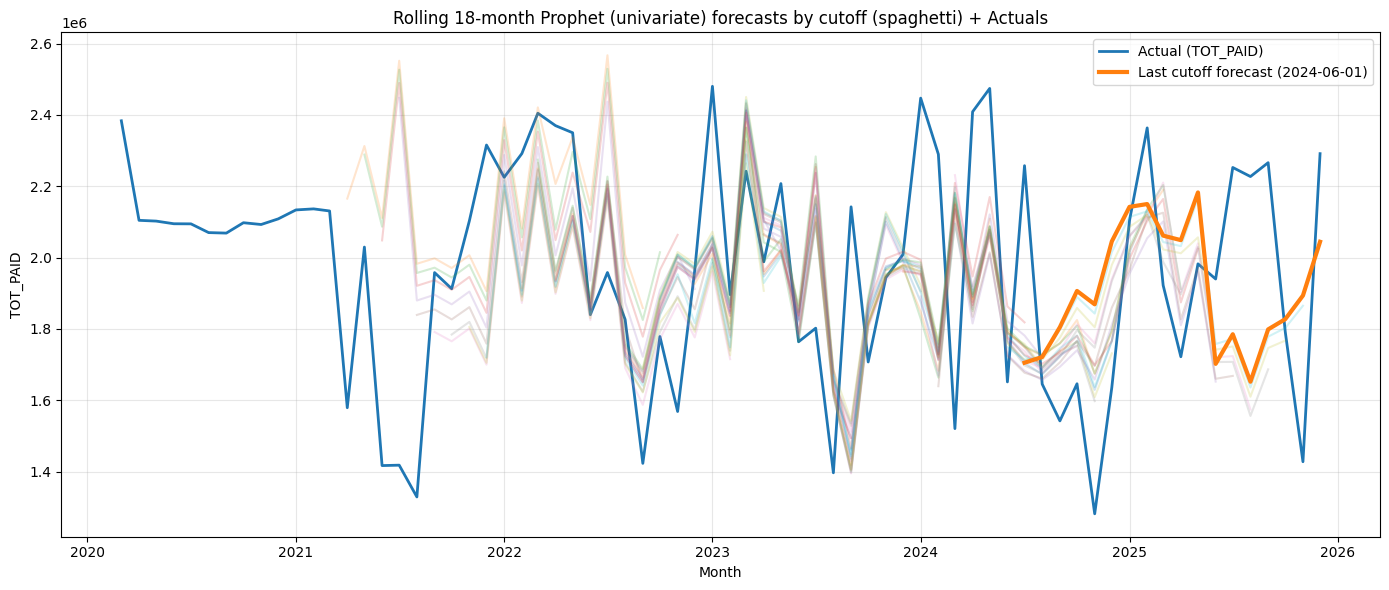

In [4]:
# ============================================================
### Rooling 187 months forecast in test period ###

# Rolling-cutoff visual demo (Prophet UNIVARIATE)
# - Uses cutoffs >= SELECTION_CUTOFF_START
# - For each cutoff: train on last 60 months up to cutoff (inclusive)
# - Forecast next 18 months
# - Produces a “spaghetti” plot of rolling 18M forecasts + actuals
# ============================================================

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet  # make sure prophet is installed

# -----------------------------
# Config (match your single-trend setup)
# -----------------------------
PATH = r"\\Sherwood\accounting\Share\Finance Meetings & Reports\Monthly Reports\BCM Report Monthly\Power BI Report\Forecasting Method\0_data_input_monthly.csv"

DATE_COL = "ACC_MONTH"
Y_COL = "TOT_PAID"

H = 18
TRAIN_WINDOW_MONTHS = 60
MIN_TRAIN_MONTHS = 60

SELECTION_CUTOFF_START = pd.Timestamp("2021-03-01")

# outlier period (same as your model)
OUTLIER_START = pd.Timestamp("2020-04-01")
OUTLIER_END   = pd.Timestamp("2021-03-01")

# Prophet priors (same as your model)
CP = 0.05
SP = 10.0

# >>> ADDED: changepoint controls <<<
N_CHANGEPOINTS = 25       # try 25–60 for monthly data
CHANGEPOINT_RANGE = 0.90  # allow changepoints through 90% of history (vs default 0.8)

# -----------------------------
# Helpers
# -----------------------------
def fill_outlier_with_past_ma(s: pd.Series, start: pd.Timestamp, end: pd.Timestamp, window_months: int = 24) -> pd.Series:
    s = s.astype(float).copy()
    outlier_idx = s.loc[start:end].index
    for d in outlier_idx:
        hist_end = d - pd.DateOffset(months=1)
        hist_start = d - pd.DateOffset(months=window_months)
        hist = s.loc[hist_start:hist_end].dropna()
        if len(hist) == 0:
            hist2 = s.loc[:hist_end].dropna()
            fill_val = float(hist2.mean()) if len(hist2) else np.nan
        else:
            fill_val = float(hist.tail(window_months).mean())
        s.loc[d] = fill_val
    return s

def prophet_univar_forecast(
    train_series: pd.Series,
    future_index: pd.DatetimeIndex,
    cp=CP,
    sp=SP,
    n_changepoints=N_CHANGEPOINTS,
    changepoint_range=CHANGEPOINT_RANGE
) -> pd.Series:
    """
    Prophet univariate on monthly data.
    """
    s = train_series.astype(float).dropna()
    if len(s) < 12:
        return pd.Series(np.nan, index=future_index)

    train_df = s.reset_index()
    train_df.columns = ["ds", "y"]

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode="additive",
        changepoint_prior_scale=cp,
        seasonality_prior_scale=sp,
        # >>> ADDED <<<
        n_changepoints=int(n_changepoints),
        changepoint_range=float(changepoint_range),
    )
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        m.fit(train_df)

    fut = pd.DataFrame({"ds": future_index})
    yhat = m.predict(fut)["yhat"].values
    return pd.Series(yhat, index=future_index, dtype=float)


# -----------------------------
# Read + prepare data
# -----------------------------
df = pd.read_csv(PATH)
df.columns = [c.strip() for c in df.columns]

df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.dropna(subset=[DATE_COL]).copy()
df[DATE_COL] = df[DATE_COL].dt.to_period("M").dt.to_timestamp(how="start")

df[Y_COL] = pd.to_numeric(df[Y_COL], errors="coerce")

df = df.sort_values(DATE_COL).set_index(DATE_COL).asfreq("MS")
df[Y_COL] = fill_outlier_with_past_ma(df[Y_COL], OUTLIER_START, OUTLIER_END, window_months=24)

# keep only months with actuals
df = df.dropna(subset=[Y_COL]).copy()

all_months = df.index.dropna()
last_date = all_months.max()

# last cutoff must allow a full 18-month test window inside actual range
cutoffs = [
    d for d in all_months
    if (d >= SELECTION_CUTOFF_START) and (d + pd.DateOffset(months=H) <= last_date)
]

print(f"Data last actual month: {last_date.date()}")
print(f"Selection cutoff start: {SELECTION_CUTOFF_START.date()}")
print(f"Cutoffs count: {len(cutoffs)}")
if cutoffs:
    print(f"First cutoff: {min(cutoffs).date()}  |  Last cutoff: {max(cutoffs).date()}")

if not cutoffs:
    raise ValueError("No valid cutoffs found. Check last_date vs SELECTION_CUTOFF_START and H=18.")


# -----------------------------
# Rolling forecasts (Prophet univariate)
# -----------------------------
rows = []
for cutoff in cutoffs:
    train_full = df.loc[:cutoff, Y_COL].copy()
    train = train_full.tail(TRAIN_WINDOW_MONTHS).copy()

    if train.dropna().shape[0] < MIN_TRAIN_MONTHS:
        continue

    future_idx = pd.date_range(cutoff + pd.DateOffset(months=1), periods=H, freq="MS")
    yhat = prophet_univar_forecast(
        train,
        future_idx,
        cp=CP,
        sp=SP,
        n_changepoints=N_CHANGEPOINTS,
        changepoint_range=CHANGEPOINT_RANGE
    )

    # attach actuals for the same future months (within available history)
    y_actual = df[Y_COL].reindex(future_idx)

    tmp = pd.DataFrame({
        "cutoff": cutoff,
        "ds": future_idx,
        "yhat": yhat.values,
        "y_actual": y_actual.values,
    })
    rows.append(tmp)

roll_fc = pd.concat(rows, ignore_index=True)
roll_fc["cutoff"] = pd.to_datetime(roll_fc["cutoff"])
roll_fc["ds"] = pd.to_datetime(roll_fc["ds"])

print("Rolling forecast rows:", roll_fc.shape[0])
print("Last forecasted month (max ds):", roll_fc["ds"].max().date())


# -----------------------------
# Plot: “spaghetti” rolling 18M forecasts + actuals
# -----------------------------
plot_start = SELECTION_CUTOFF_START - pd.DateOffset(months=12)
plot_end = roll_fc["ds"].max()

actual_plot = df.loc[plot_start:plot_end, Y_COL].copy()

plt.figure(figsize=(14, 6))

# Actuals
plt.plot(actual_plot.index, actual_plot.values, linewidth=2, label="Actual (TOT_PAID)")

# Rolling forecasts (one line per cutoff)
for c, g in roll_fc.groupby("cutoff"):
    g = g.sort_values("ds")
    plt.plot(g["ds"], g["yhat"], alpha=0.20)

# Highlight the last cutoff forecast (thicker)
last_cutoff = roll_fc["cutoff"].max()
g_last = roll_fc[roll_fc["cutoff"] == last_cutoff].sort_values("ds")
plt.plot(g_last["ds"], g_last["yhat"], linewidth=3, label=f"Last cutoff forecast ({last_cutoff.date()})")

plt.title("Rolling 18-month Prophet (univariate) forecasts by cutoff (spaghetti) + Actuals")
plt.xlabel("Month")
plt.ylabel("TOT_PAID")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# roll_fc.to_csv("rolling_prophet_univariate_18m_by_cutoff.csv", index=False)
